
## Analyze A/B Test Results

This project will assure you have mastered the subjects covered in the statistics lessons.  The hope is to have this project be as comprehensive of these topics as possible.  Good luck!

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)





<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.


In [86]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import scipy.stats as stats
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [87]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the below cell to find the number of rows in the dataset.


In [88]:
df.shape

(294478, 5)

c. The number of unique users in the dataset.


In [89]:
df.user_id.nunique()

290584

d. The proportion of users converted.


In [90]:
df['converted'].sum() / len(df)

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't line up.

In [91]:
df.groupby(['group', 'landing_page'])['landing_page'].count()

group      landing_page
control    new_page          1928
           old_page        145274
treatment  new_page        145311
           old_page          1965
Name: landing_page, dtype: int64

In [92]:
# to specify the number sum the (old page with teratment ) + control with new page 
len(df.query("(group == 'control') and (landing_page == 'new_page')") + df.query("(group == 'treatment') and\
                                                                                 (landing_page == 'old_page')"))

3893

f. Do any of the rows have missing values?

In [93]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to provide how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [94]:
# Remove rows 
df2 = df.drop(df[((df.group == 'control') & (df.landing_page == 'new_page')) | \
                 ((df.group == 'treatment') & (df.landing_page == 'old_page'))].index)

In [95]:
df2.shape


(290585, 5)

In [96]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [97]:
df2.user_id.nunique()


290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [98]:
duplicate_user = df2[df2['user_id'].duplicated()].user_id
duplicate_user

2893    773192
Name: user_id, dtype: int64

c. What is the row information for the repeat **user_id**? 

In [99]:
df2[df2['user_id'] == duplicate_user.iloc[0]]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [100]:
df2.drop_duplicates(['user_id'], inplace=True)
df2.shape

(290584, 5)

`4.` Use **df2** in the below cells to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [101]:
df2['converted'].sum() / len(df2)


0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [102]:
control_conversion = df2[df2['group'] == 'control']['converted'].sum() / len(df2[df2['group'] == 'control'])
control_conversion

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [103]:
treatment_conversion = df2[df2['group'] == 'treatment']['converted'].sum() / len(df2[df2['group'] == 'treatment'])
treatment_conversion


0.11880806551510564

d. What is the probability that an individual received the new page?

In [104]:
df2[df2['landing_page'] == 'new_page']['group'].count() / len(df2)

0.5000619442226688

e. Consider your results from a. through d. above, and explain below whether you think there is sufficient evidence to say that the new treatment page leads to more conversions.

In [105]:
obs_diff = treatment_conversion - control_conversion
obs_diff

-0.0015782389853555567

**There is not sufficient evidence to say that the new treatment page leads to more conversions.
The probability of conversion is Little bit in the treatment group than in the control group.**

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.


 **H0:pnew−pold≤0**
 
 **H1:pnew−pold>0**

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>


a. What is the **convert rate** for $p_{new}$ under the null? 

In [106]:
p_new = df2['converted'].sum() / len(df2)
p_new

0.11959708724499628

b. What is the **convert rate** for $p_{old}$ under the null? <br><br>


In [107]:
p_old = df2['converted'].sum() / len(df2)
p_old

0.11959708724499628

c. What is $n_{new}$?

In [108]:
#groub-by
df2.groupby(['group', 'landing_page'])['landing_page'].count()


group      landing_page
control    old_page        145274
treatment  new_page        145310
Name: landing_page, dtype: int64

In [109]:
n_new = df2[df2['landing_page'] == 'new_page']['landing_page'].count()
n_new

145310

d. What is $n_{old}$?

In [110]:
n_old = df2[df2['landing_page'] == 'old_page']['landing_page'].count()
n_old

145274

e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [111]:
treatmet_df = df2.query('group == "treatment"')
sample_new = treatmet_df.sample(n_new, replace=True)
new_page_converted = sample_new['converted']
new_page_converted.mean()

0.11780331704631478

f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.


In [112]:
control_df = df2.query('group == "control"')
sample_old = control_df.sample(n_old, replace=True)
old_page_converted = sample_old['converted']
old_page_converted.mean()

0.12086815259440781

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [113]:
p_diff_simulate = new_page_converted.mean() - old_page_converted.mean()
p_diff_simulate

-0.003064835548093031

h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in a numpy array called **p_diffs**.


In [114]:
#get the sampling distribution of the conversion differences
control_conv_prob = []
treatment_conv_prob = []
p_diffs = []

# for loops
for _ in range(10000):
    sample_old2 = control_df.sample(n_old, replace=True)
    sample_new2 = treatmet_df.sample(n_new, replace=True)

    control_conversion = sample_old2['converted'].sum() / n_old
    treatment_conversion = sample_new2['converted'].sum() / n_new

# numpy binomial function would generate the distribution given that the null is true
#control_conversion = np.random.binomial(n_old, p_old, 10000) / n_old
#treatment_conversion = np.random.binomial(n_new, p_new, 10000) / n_new
    
    control_conv_prob.append(control_conversion)
    treatment_conv_prob.append(treatment_conversion)
    p_diffs.append(treatment_conversion - control_conversion)
    
p_diffs = np.array(p_diffs)

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.


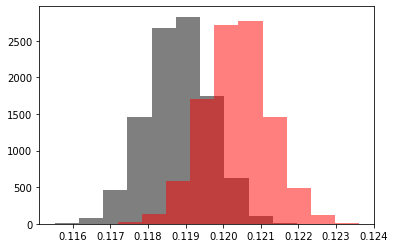

In [115]:
plt.hist(treatment_conv_prob, alpha=0.5, color='black')
plt.hist(control_conv_prob, alpha=0.5, color='red');

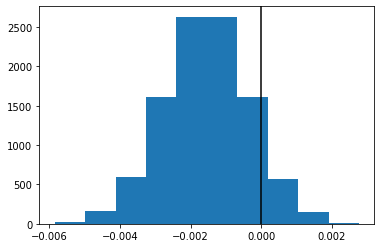

In [116]:
# I simulated a sampling distribution for the conversion difference by bootstrapping
plt.hist(p_diffs);
plt.axvline(x=0, color='black');

In [117]:
# the null hypothesis says the difference is less than or equal to 0
# there is 90% probability that the difference is less than 0 and therefore fitting the H0
stats.percentileofscore(p_diffs, 0)

90.13

In [118]:
(p_diffs < 0).mean()

0.9013

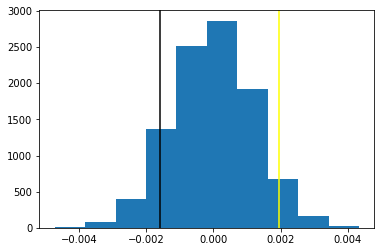

In [119]:
# alternatively, we can simulate the differences under the null, i.e. when the mean difference is 0
# now we can look at how likely it is we would observe our observed difference or a more extreme values in favour of H1, 
# given that the H0 is true, which in our case means difference values higher than the obs_diff
null_vals = np.random.normal(0, p_diffs.std(), p_diffs.size)
plt.hist(null_vals)
plt.axvline(x=obs_diff, color='black');
plt.axvline(x=np.percentile(null_vals, 95), color='yellow');

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [120]:
# proportion of the p_diffs greater than the actual difference observed is 50%
# however, if binomial was used to bootstrap, we would have the distribution under the null 
# and then it would be 90%, our p-value
(p_diffs > obs_diff).mean()

0.5111

In [121]:
p_value = (null_vals > obs_diff).mean()
p_value

0.903

In [122]:
p_value = 1 - stats.percentileofscore(null_vals, obs_diff) / 100
p_value

0.903

In [123]:
# I would only be able to reject the null if the observed difference was higher than 0.002
np.percentile(null_vals, 95)

0.001942747875107168

k. In words, explain what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?


**We calculated the p-value. The p-value of 0.9 says that given that the null hypothesis is true, there is 90% probability of observing our conversion difference (or one more extreme in favour of the alternative).
The null therefore cannot be rejected (with a type I error rate of 5% or any other reasonable type I error rate) and we should keep the old page.**


l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.


In [124]:
import statsmodels.api as sm

convert_old =df2.query('(converted == 1) and (group == "control")').count()
convert_new = df2.query('(converted == 1) and (group == "treatment")').count()
n_old = df2.query('group == "control"').count()
n_new = df2.query('group == "treatment"').count() 

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.


In [125]:
counts = [convert_new.iloc[0], convert_old.iloc[0]]
nobs = [n_new.iloc[0], n_old.iloc[0]]

In [126]:
# I select the larger in the alternative attribute because that is our H1
z_score, p_value = sm.stats.proportions_ztest(counts, nobs, alternative='larger')
p_value

0.9050583127590245

In [127]:
# z-score tells us it is exactly the z-score value (-1.3) standard deviations from the mean of N(0,1) distribution
z_score

-1.3109241984234394

In [128]:
from scipy.stats import norm
# critical value for 5% type I error level
# we cannot reject the null because the z-score is lower than the critical value
critical_value = norm.ppf(1 - (0.05))
critical_value

1.6448536269514722

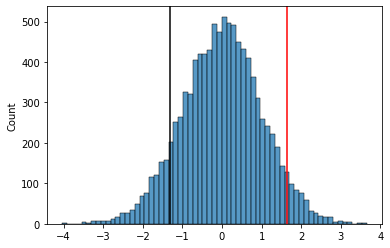

In [129]:
# histplot plot
g = sns.histplot(np.random.normal(0, 1, 10000))
g.axvline(x=z_score, color='black')
g.axvline(x=critical_value, color='red');

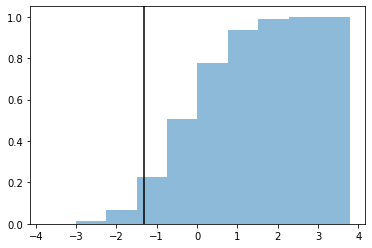

In [130]:
# cdf plot
plt.hist(np.random.normal(0, 1, 10000), density=True, cumulative=True, alpha=0.5)
plt.axvline(x=z_score, color='black');

In [131]:
# z-score is on the 10th percentile of the distribution 
percentile = norm.cdf(z_score)
percentile

0.09494168724097551

In [132]:
# p-value can be calculated as follows from the z-score
p_value = 1 - norm.cdf(z_score)
p_value

0.9050583127590245

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?


**The findings of both parts agree.**

**Z-score is a statistic measured in terms of standard deviations from the mean that can be used to calculate p-value and decide on the hypothesis testing conclusions as is shown above.**

**The p-value means that we have 90% probability to get the observed difference given that the null is true. It is safe to say that we do not have evidence that the new page leads to more conversions and we should stick to the old page.** 

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you acheived in the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?


**Logistic regression should be used for this case.**

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, you first need to create a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.


In [133]:
df2['intercept'] = 1
df2['ab_page'] = pd.get_dummies(df2['group'])['treatment']
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


c. Use **statsmodels** to import your regression model.  Instantiate the model, and fit the model using the two columns you created in part **b.** to predict whether or not an individual converts.


In [134]:
log_mod = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
results = log_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.


In [135]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Sat, 14 Jan 2023   Pseudo R-squ.:               8.077e-06
Time:                        18:16:41   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in the **Part II**?


**The p-value associated with ab_page is 0.19. The null cannot be rejected because 0.19 is above our Type I error threshold of 0.05.
The negative coefficient of ab_page is therefore insignificant, so we cannot say that the new page has any effect on the conversion rate.
The old page should therefore be kept because the new page did not prove to have higher conversions.
This conclusion is the same like in the previous part, however the p-value differs from the value found in Part II due to different hypotheses being tested in the two parts.
In this case, we are doing a two-tailed test, so the alternative is that the new page has a different conversion rate than the old page (in whichever direction). So if the new page actually performs worse than the old page, it would still fit the alternative hypothesis and this is why the p-value decreased (due to our negative observed difference).
This is the case because the null of the logistic regression is that the new page has no impact on conversions, i.e. that the probability of conversion is the same with the old page and the new page. The alternative for this case is that the probabilities are different.
On the other hand, in the previous part we did one-tailed test, in which the alternative was that the new page has higher conversions.**


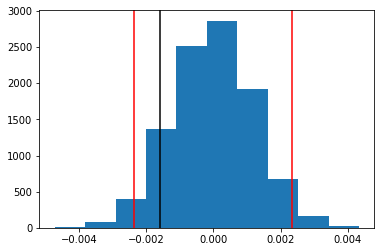

In [136]:
# to make a comparison to the previous part, having a two-tailed test there would mean that we would reject the null 
# if the observed conversion difference is either lower than -0.0023 or higher than 0.0023
# we see that we are definitely somewhat closer to the rejection region (i.e. there is also a lower p-value) in this case 
# than we were in the one-tailed case
plt.hist(null_vals)
plt.axvline(x=obs_diff, color='black')
plt.axvline(x=np.percentile(null_vals, 2.5), color='red')
plt.axvline(x=np.percentile(null_vals, 97.5), color='red');

In [137]:
print('2.5th percentile:', np.percentile(null_vals, 2.5))
print('97.5th percentile:', np.percentile(null_vals, 97.5))

2.5th percentile: -0.002377752149365339
97.5th percentile: 0.0023307985443747053


f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?


**We only look at the effect of the new page on the conversion rate right now. However, in reality many other factors probably also have influence on whether or not the user converts, such as when they are existing customers and might suffer from change aversion, or that they might convert due to other changes happening on the site or for some other reasons than being presented with the new page, for example due to their specific customer characteristics.**

**The disadvantage to adding more terms to the regression is for example the multiple comparison problem, which means that the more metrics are evaluated, the more likely it is to observe significant differences just by chance. The more inferences are made, the more likely erroneous inferences are to occur.**
**Adding more terms will always improve the model regardless of whether the added term adds a significant value. Adding many independent variables can potentially lead to overfitting, where our training data is exactly modeled, but the estimates do not work for new unknown data. The estimation can for example also suffer from multicollinearity, which occurs when we have highly correlated predictors.**
**Another potential issues to consider are Simpson's paradox or confounding variables.**

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. You will need to read in the **countries.csv** dataset and merge together your datasets on the approporiate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.


In [138]:
countries_df = pd.read_csv('./countries.csv')
df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')
df_new.head()


,country,timestamp,group,landing_page,converted,intercept,ab_page
user_id,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1


In [139]:
# majority of customers comes from US, let's use it as the reference
df_new['country'].value_counts()

US    203619
UK     72466
CA     14499
Name: country, dtype: int64

In [140]:
### Create the necessary dummy variables
dum_countries = pd.get_dummies(df_new['country'])
df4 = dum_countries.join(df_new, how='inner')
df4.head()

,CA,UK,US,country,timestamp,group,landing_page,converted,intercept,ab_page
user_id,,,,,,,,,,
834778,0,1,0,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0
928468,0,0,1,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1
822059,0,1,0,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1
711597,0,1,0,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0
710616,0,1,0,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1


In [141]:
log_mod1 = sm.Logit(df4['converted'], df4[['intercept', 'UK', 'CA']])
results = log_mod1.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            2
Date:                Sat, 14 Jan 2023   Pseudo R-squ.:               1.521e-05
Time:                        18:21:57   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1984
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9967      0.007   -292.314      0.000      -2.010      -1.983
UK             0.0099      0.013      0.746      0.456      -0.016       0.036
CA            -0.0408      0.027     -1.518      0.129      -0.093       0.012
==============================================================================
"""

The model above includes only the country of customers and no other explanatory variables. We see that these predictors are insignificant (their p-values are high), i.e. we cannot say that solely being from either UK or CA (as opposed to US) has a significant effect on the conversion rate.

In [142]:
log_mod2 = sm.Logit(df4['converted'], df4[['intercept', 'ab_page', 'UK', 'CA']])
results = log_mod2.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Sat, 14 Jan 2023   Pseudo R-squ.:               2.323e-05
Time:                        18:22:47   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9893      0.009   -223.763      0.000      -2.007      -1.972
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
UK             0.0099      0.013      0.743      0.457      -0.016       0.036
CA            -0.0408      0.027     -1.516      0.130      -0.093       0.012
==============================================================================
"""

Adding ab_page to the model makes no difference, all variables are still insignificant and the null cannot be rejected.

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion. Create the necessary additional columns, and fit the new model.

Provide the summary results, and your conclusions based on the results.

In [143]:
UK_newpage = df4['ab_page'] * df4['UK']
df4['UK_newpage'] = UK_newpage

In [144]:
CA_newpage = df4['ab_page'] * df4['CA']
df4['CA_newpage'] = CA_newpage
df4.head()

,CA,UK,US,country,timestamp,group,landing_page,converted,intercept,ab_page,UK_newpage,CA_newpage
user_id,,,,,,,,,,,,
834778,0,1,0,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,0,0
928468,0,0,1,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,0
822059,0,1,0,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,1,0
711597,0,1,0,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,0,0
710616,0,1,0,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,1,0


h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.


In [145]:
### Fit Your Linear Model And Obtain the Results
log_mod3 = sm.Logit(df4['converted'], df4[['intercept', 'UK', 'CA', 'UK_newpage', 'CA_newpage']])
results = log_mod3.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290579
Method:                           MLE   Df Model:                            4
Date:                Sat, 14 Jan 2023   Pseudo R-squ.:               2.417e-05
Time:                        18:23:18   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.2729
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9967      0.007   -292.314      0.000      -2.010      -1.983
UK             0.0045      0.018      0.257      0.797      -0.030       0.039
CA            -0.0073      0.037     -0.196      0.844      -0.080       0.065
UK_newpage     0.0108      0.023      0.475      0.635      -0.034       0.056
CA_newpage    -0.0674      0.052     -1.297      0.195      -0.169       0.034
==============================================================================
"""

In [146]:
log_mod4 = sm.Logit(df4['converted'], df4[['intercept', 'ab_page', 'UK', 'CA', 'UK_newpage', 'CA_newpage']])
results = log_mod4.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Sat, 14 Jan 2023   Pseudo R-squ.:               3.482e-05
Time:                        18:23:43   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1920
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9865      0.010   -206.344      0.000      -2.005      -1.968
ab_page       -0.0206      0.014     -1.505      0.132      -0.047       0.006
UK            -0.0057      0.019     -0.306      0.760      -0.043       0.031
CA            -0.0175      0.038     -0.465      0.642      -0.091       0.056
UK_newpage     0.0314      0.027      1.181      0.238      -0.021       0.084
CA_newpage    -0.0469      0.054     -0.872      0.383      -0.152       0.059
==============================================================================
"""

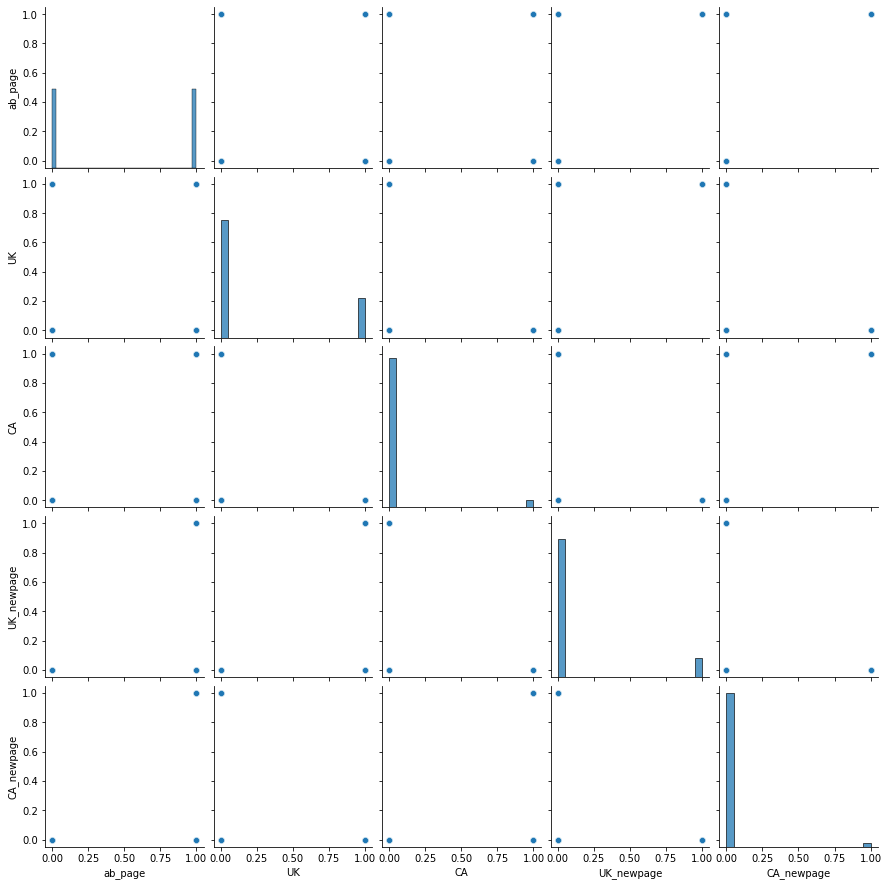

In [147]:
# pairwise correlations
# these are normally a good way to check for multicollinearity, however since we only have categorical variables 
# (which is also the probable reason why we cannot fit any good model), we do not learn much about their relationship
sns.pairplot(df4[['ab_page', 'UK', 'CA', 'UK_newpage', 'CA_newpage']]);
# we learn that number of customer with the new page is the same as with the old page
# we learn that UK customers with new page convert less than UK customers in general
# UK customers convert high above our overall conversion rate of around 12%

<a id='conclusions'></a>
## Conclusions

We used several ways to test whether the introduction of the new page increases conversions.
The conclusion in all of them is that the new page did not prove to be better than the old page and we do not have the evidence to switch to the new page.

We failed to find a model that would be good at predicting conversions based on the data we have available.